In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from IPython.core.magic import register_cell_magic

# Defining Reusable Functions

In [2]:
def correlation_heatmap(df: pd.DataFrame, x=8, y=6, dpi=100) :
    # First calculate the correlation matrix using pandas
    correlation_matrix = df.corr()
    
    # Create the heatmap using seaborn
    plt.figure(figsize=(x, y), dpi=dpi)
    sns.heatmap(correlation_matrix, 
                annot=True,  # This shows the numbers in each cell
                fmt='.2f',   # Format to 2 decimal places
                cmap='RdBu_r',  # This gives you the red-white-blue colormap similar to the image
                center=0,     # Centers the colormap at 0
                square=True,  # Makes the cells square
                vmin=-1,     # Sets the minimum value for the colormap
                vmax=1)      # Sets the maximum value for the colormap
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # Optional: adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [3]:
@register_cell_magic
def skip(line, cell):
    return

# Analysing the first available Parquet File

In [4]:
dirs = [d for d in Path(r'data\series_train.parquet').iterdir() if d.is_dir()]

def analyse_parquet(parquet_file: Path) :
  return pd.read_parquet(parquet_file)
  
for dir in dirs:
  row_id = str(dir).split("id=")[1]
  parquet_file = next(dir.glob("*.parquet"))

df = analyse_parquet(parquet_file)
df.head()

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.947155,-0.054616,0.127157,0.036699,8.424445,0.0,0.500000,4189.000000,44340000000000,1,1,301.0
1,1,0.771766,0.415199,0.013030,0.019078,1.435498,0.0,1.238095,4188.833496,44345000000000,1,1,301.0
2,2,-0.117449,0.415044,0.746269,0.039424,52.555592,0.0,1.976190,4188.666504,44350000000000,1,1,301.0
3,3,-0.412414,0.682195,0.123881,0.054400,6.984442,0.0,2.714286,4188.500000,44355000000000,1,1,301.0
4,4,-0.215429,0.657094,0.498684,0.041109,34.235992,0.0,3.452381,4188.333496,44360000000000,1,1,301.0


In [5]:
df.columns

Index(['step', 'X', 'Y', 'Z', 'enmo', 'anglez', 'non-wear_flag', 'light',
       'battery_voltage', 'time_of_day', 'weekday', 'quarter',
       'relative_date_PCIAT'],
      dtype='object')

## Removing Rows where accelerometer hasn't been worn

In [6]:
rows_before = len(df)

# Apply filter
wear_df = df[df['non-wear_flag'] != 1]

# Count rows after filtering
rows_after = len(wear_df)

# Calculate number of rows removed
rows_removed = rows_before - rows_after
rows_removed

224884

## Analaysis of Accelerometer data wrt Time of day (hours)

In [7]:
# Convert nanoseconds to hours of day
# First convert to seconds by dividing by 1e9, then get hours by dividing seconds by 3600
wear_df['time_of_day_hours'] = ((wear_df['time_of_day'] / 1e9) % 86400 / 3600).astype(int)
wear_df['time_of_day_hours'].head()

C:\Users\User\AppData\Local\Temp\ipykernel_97040\27349580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wear_df['time_of_day_hours'] = ((wear_df['time_of_day'] / 1e9) % 86400 / 3600).astype(int)


0    12
1    12
2    12
3    12
4    12
Name: time_of_day_hours, dtype: int64

In [8]:
# Create a single DataFrame with means of all desired columns
avg_df_hours = wear_df.groupby('time_of_day_hours')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()
avg_df_hours.head()

,time_of_day_hours,X,Y,Z,anglez,light,enmo
0,0,0.155875,0.075954,-0.026142,-5.501348,4.860384,0.003676
1,1,-0.220306,0.161074,-0.295415,-22.773060,4.870170,0.004583
2,2,0.051411,-0.129772,-0.407232,-28.732391,5.687574,0.005606
3,3,-0.089633,0.020714,-0.312193,-25.195501,6.009756,0.003391
4,4,-0.108234,0.102704,-0.075998,-8.072747,7.111255,0.003330


In [9]:
def get_figure(ax, x, y, title, xlabel, ylabel):
    
    ax.plot(x, y, 'b-', linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Set x-axis ticks for every hour
    ax.set_xticks(range(0, 24))
    ax.tick_params(axis='x', rotation=45)  # Rotate x ticks by 45 degrees
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    return ax    

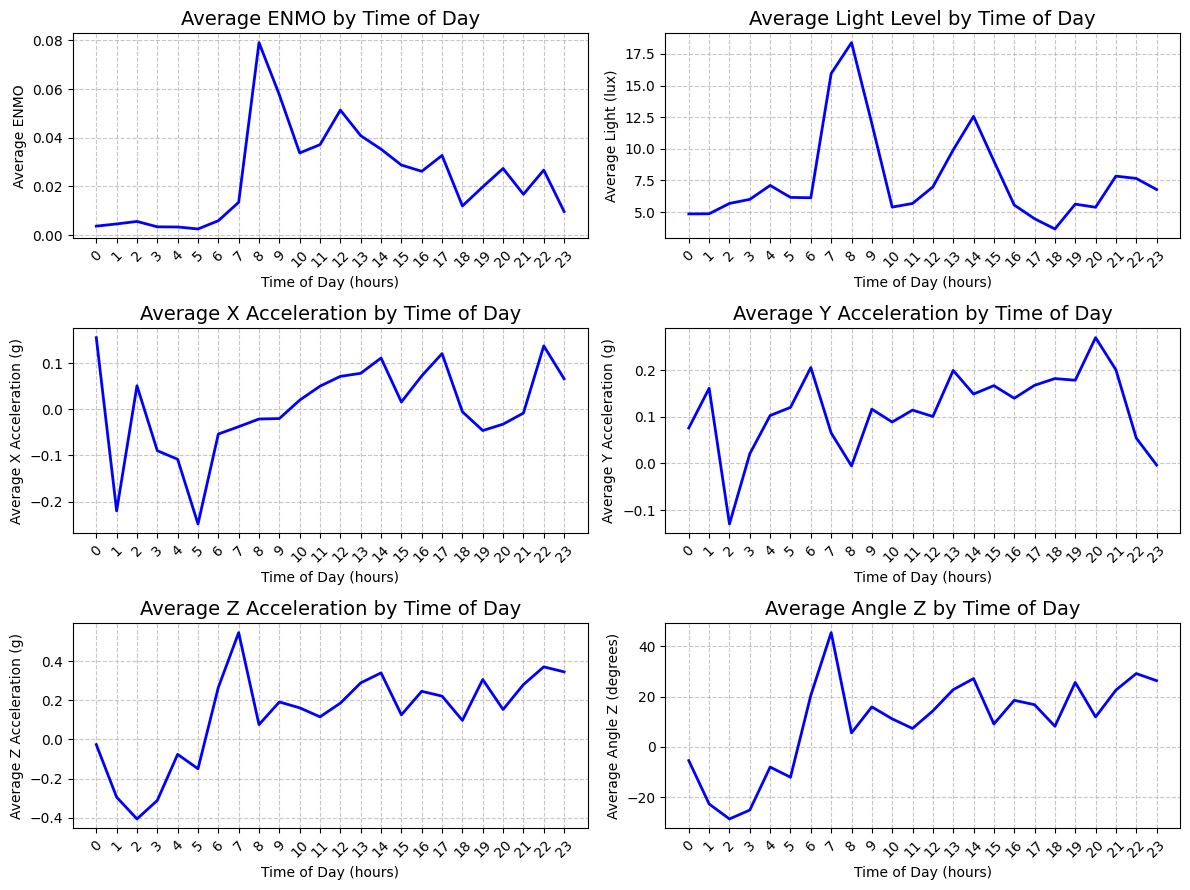

In [10]:
# Create the plot
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 9))

get_figure(ax1, avg_df_hours['time_of_day_hours'], avg_df_hours['enmo'], 
          'Average ENMO by Time of Day', 
          'Time of Day (hours)', 
          'Average ENMO')

get_figure(ax2, avg_df_hours['time_of_day_hours'], avg_df_hours['light'], 
          'Average Light Level by Time of Day', 
          'Time of Day (hours)', 
          'Average Light (lux)')

get_figure(ax3, avg_df_hours['time_of_day_hours'], avg_df_hours['X'], 
          'Average X Acceleration by Time of Day', 
          'Time of Day (hours)', 
          'Average X Acceleration (g)')

get_figure(ax4, avg_df_hours['time_of_day_hours'], avg_df_hours['Y'], 
          'Average Y Acceleration by Time of Day', 
          'Time of Day (hours)', 
          'Average Y Acceleration (g)')

get_figure(ax5, avg_df_hours['time_of_day_hours'], avg_df_hours['Z'], 
          'Average Z Acceleration by Time of Day', 
          'Time of Day (hours)', 
          'Average Z Acceleration (g)')

get_figure(ax6, avg_df_hours['time_of_day_hours'], avg_df_hours['anglez'], 
          'Average Angle Z by Time of Day', 
          'Time of Day (hours)', 
          'Average Angle Z (degrees)')

plt.tight_layout()
plt.show()

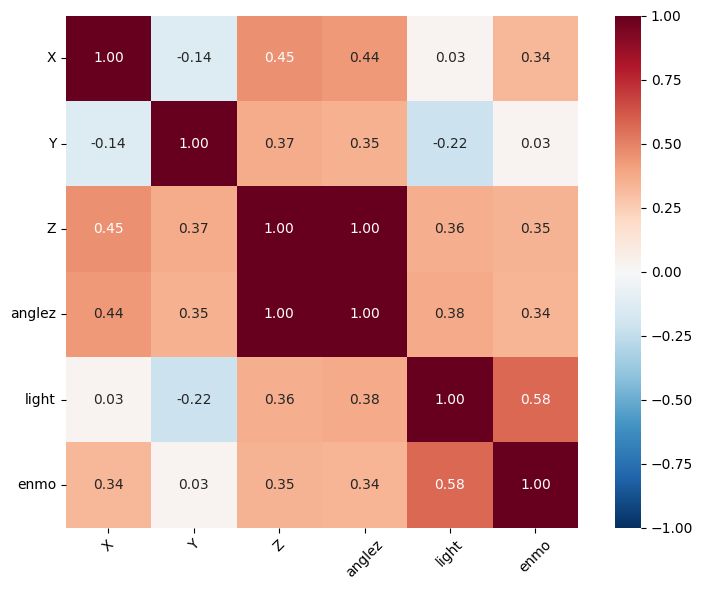

In [11]:
# First calculate the correlation matrix using pandas
correlation_heatmap(avg_df_hours.drop('time_of_day_hours', axis=1))

In [12]:
# Create a dictionary to store the new columns
flattened_data = {}

# For each variable, create 24 columns
for var in ['X', 'Y', 'Z', 'anglez', 'light']:
    for hour in range(24):
        # Get the value for this hour
        value = avg_df_hours[avg_df_hours['time_of_day_hours'] == hour][var].iloc[0] if not avg_df_hours[avg_df_hours['time_of_day_hours'] == hour].empty else None
        # Create new column name (e.g., 'X_1', 'X_2', etc.)
        col_name = f'{var}_{hour}'
        flattened_data[col_name] = [value]

# Create new dataframe
flat_df = pd.DataFrame(flattened_data)

# Optionally, sort columns to group variables together
flat_df = flat_df.reindex(sorted(flat_df.columns), axis=1)

flat_df

,X_0,X_1,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,...,light_21,light_22,light_23,light_3,light_4,light_5,light_6,light_7,light_8,light_9
0,0.155875,-0.220306,0.020144,0.050523,0.071821,0.078394,0.111609,0.016089,0.072837,0.121217,...,7.84535,7.662183,6.786202,6.009756,7.111255,6.164332,6.136124,15.945152,18.387943,11.996333


## Now evaluating the average data per weekday

In [13]:
def get_continuous_sequence(numbers):
    # Convert pandas Series to list if needed
    if hasattr(numbers, 'tolist'):
        numbers = numbers.tolist()
    
    # Now check for empty list
    if not numbers or len(numbers) == 0:
        return []
        
    continuous = [numbers[0]]  # Initialize with first number
    for i in range(1, len(numbers)):
        current = numbers[i]
        prev = numbers[i-1]
        
        # If current number is less than previous, it means we've started a new week
        if current < prev:
            # Add 7 to make it continue from the previous week
            continuous.append(continuous[-1] + (current - prev + 7))
        # If current equals previous, keep the same continuous number
        elif current == prev:
            continuous.append(continuous[-1])
        # If current is greater than previous, add the difference
        else:
            continuous.append(continuous[-1] + (current - prev))
            
    return continuous

In [14]:
%%skip
wear_df['continuous_weekdays'] = get_continuous_sequence(wear_df['weekday']) 
wear_df['continuous_weekdays'].unique()

In [17]:
# Create a single DataFrame with means of all desired columns
avg_df_weekday = wear_df.groupby('weekday')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()
avg_df_weekday

,weekday,X,Y,Z,anglez,light,enmo
0,1,-0.196692,0.063857,-0.111319,-8.651134,10.358100,0.048056
1,2,0.108818,0.001465,0.162281,12.244626,6.193349,0.022635
2,3,-0.097905,0.390105,0.284356,23.267166,4.397866,0.017674
3,4,0.085857,0.034923,0.588261,46.338799,6.051581,0.017238
4,5,0.361525,0.014873,0.036530,3.112057,10.290066,0.044589
5,6,-0.000603,0.247711,0.015005,-3.635057,6.261016,0.013636
6,7,-0.005239,0.134496,0.142853,10.823056,16.152447,0.037028


In [18]:
def get_figure_weekday(ax, x, y, title, xlabel, ylabel):
    
    ax.plot(x, y, 'b-', linewidth=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Set x-axis ticks for every hour
    # Set x-axis ticks
    # ax.set_xticks(range(len(x)))  # This sets a tick for each x value
    # ax.tick_params(axis='x', rotation=45)  # Rotate x ticks by 45 degrees
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    return ax    

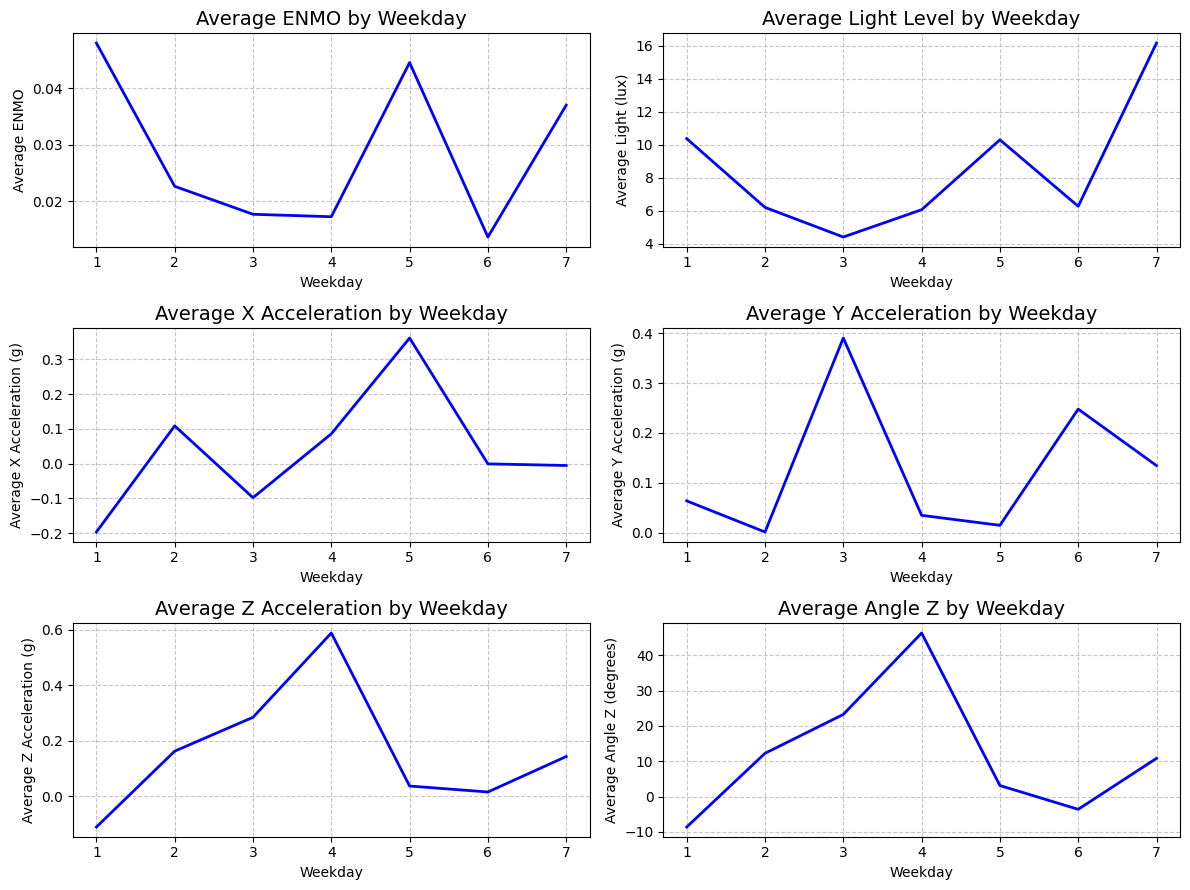

In [20]:
# Create the plot
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 9))

get_figure_weekday(ax1, avg_df_weekday['weekday'], avg_df_weekday['enmo'], 
          'Average ENMO by Weekday', 
          'Weekday', 
          'Average ENMO')

get_figure_weekday(ax2, avg_df_weekday['weekday'], avg_df_weekday['light'], 
          'Average Light Level by Weekday', 
          'Weekday', 
          'Average Light (lux)')

get_figure_weekday(ax3, avg_df_weekday['weekday'], avg_df_weekday['X'], 
          'Average X Acceleration by Weekday', 
          'Weekday', 
          'Average X Acceleration (g)')

get_figure_weekday(ax4, avg_df_weekday['weekday'], avg_df_weekday['Y'], 
          'Average Y Acceleration by Weekday', 
          'Weekday',  
          'Average Y Acceleration (g)')

get_figure_weekday(ax5, avg_df_weekday['weekday'], avg_df_weekday['Z'], 
          'Average Z Acceleration by Weekday', 
          'Weekday', 
          'Average Z Acceleration (g)')

get_figure_weekday(ax6, avg_df_weekday['weekday'], avg_df_weekday['anglez'], 
          'Average Angle Z by Weekday', 
          'Weekday', 
          'Average Angle Z (degrees)')

plt.tight_layout()
plt.show()

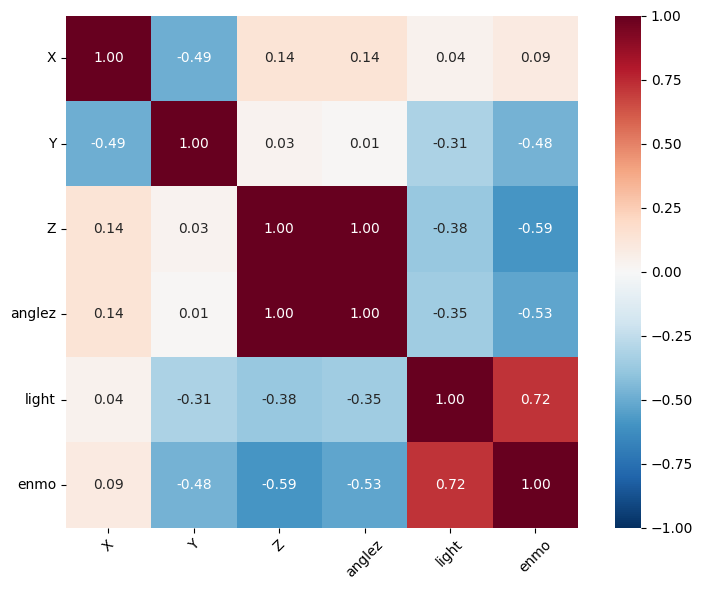

In [22]:
# First calculate the correlation matrix using pandas
correlation_heatmap(avg_df_weekday.drop('weekday', axis=1))

## Conclusions from Analysis

1. Anglez and Z are heavily correlated.
2. X, Y and Z may not be quite as useful as Enmo. Initially discarding the data. If we do not get satisfactory results, we shall consider using X, Y and Z again.
3. Light and Enmo are correlated, but since we're using just one child's Accelerometer data, it might not be the same throughout. Hence, we should ideally keep them both in.

## Flattening Hourly Data

In [23]:
# Create a dictionary to store the new columns
flattened_data = {}

# For each variable, create 24 columns
for var in ['enmo', 'light']:
    for hour in range(24):
        # Get the value for this hour
        value = avg_df_hours[avg_df_hours['time_of_day_hours'] == hour][var].iloc[0] if not avg_df_hours[avg_df_hours['time_of_day_hours'] == hour].empty else None
        # Create new column name (e.g., 'X_1', 'X_2', etc.)
        col_name = f'{var}_h{hour}'
        flattened_data[col_name] = [value]

# Create new dataframe
hourly_flat_df = pd.DataFrame(flattened_data)

# Optionally, sort columns to group variables together
# hourly_flat_df = hourly_flat_df.reindex(sorted(hourly_flat_df.columns), axis=1)

hourly_flat_df

,enmo_h0,enmo_h1,enmo_h2,enmo_h3,enmo_h4,enmo_h5,enmo_h6,enmo_h7,enmo_h8,enmo_h9,...,light_h14,light_h15,light_h16,light_h17,light_h18,light_h19,light_h20,light_h21,light_h22,light_h23
0,0.003676,0.004583,0.005606,0.003391,0.00333,0.002519,0.005899,0.013478,0.079089,0.057646,...,12.564425,9.036289,5.561802,4.479136,3.671882,5.632383,5.384964,7.84535,7.662183,6.786202


## Flattening Weekday Data

In [26]:
# Create a dictionary to store the new columns
flattened_data = {}

# For each variable, create columns for each unique weekday
for var in ['enmo', 'light']:
    # Get the unique weekdays in sorted order
    unique_weekdays = sorted(avg_df_weekday['weekday'].unique())
    
    for weekday in unique_weekdays:
        # Get the value for this weekday
        value = avg_df_weekday[avg_df_weekday['weekday'] == weekday][var].iloc[0] if not avg_df_weekday[avg_df_weekday['weekday'] == weekday].empty else None
        # Create new column name (e.g., 'enmo_1', 'enmo_2', etc.)
        col_name = f'{var}_w{weekday}'
        flattened_data[col_name] = [value]

# Create new dataframe
weekday_flat_df = pd.DataFrame(flattened_data)
# Optionally, sort columns to group variables together
# weekday_flat_df = weekday_flat_df.reindex(sorted(weekday_flat_df.columns), axis=1)
weekday_flat_df

,enmo_w1,enmo_w2,enmo_w3,enmo_w4,enmo_w5,enmo_w6,enmo_w7,light_w1,light_w2,light_w3,light_w4,light_w5,light_w6,light_w7
0,0.048056,0.022635,0.017674,0.017238,0.044589,0.013636,0.037028,10.3581,6.193349,4.397866,6.051581,10.290066,6.261016,16.152447


## Creating a combined dataframe

In [27]:
combined_df = pd.concat([hourly_flat_df, weekday_flat_df], axis=1)
combined_df.head()

,enmo_h0,enmo_h1,enmo_h2,enmo_h3,enmo_h4,enmo_h5,enmo_h6,enmo_h7,enmo_h8,enmo_h9,...,enmo_w5,enmo_w6,enmo_w7,light_w1,light_w2,light_w3,light_w4,light_w5,light_w6,light_w7
0,0.003676,0.004583,0.005606,0.003391,0.00333,0.002519,0.005899,0.013478,0.079089,0.057646,...,0.044589,0.013636,0.037028,10.3581,6.193349,4.397866,6.051581,10.290066,6.261016,16.152447


# Analysing Stats of first available Parquet File

In [28]:
compressed_df = wear_df[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].copy()
compressed_df.head()

,X,Y,Z,anglez,light,enmo
0,0.947155,-0.054616,0.127157,8.424445,0.500000,0.036699
1,0.771766,0.415199,0.013030,1.435498,1.238095,0.019078
2,-0.117449,0.415044,0.746269,52.555592,1.976190,0.039424
3,-0.412414,0.682195,0.123881,6.984442,2.714286,0.054400
4,-0.215429,0.657094,0.498684,34.235992,3.452381,0.041109


In [29]:
compressed_df.shape

(174116, 6)

In [30]:
stats = {}

for var in compressed_df.columns :
    stats[f'{var}_mean'] = [compressed_df[var].mean()]
    stats[f'{var}_median'] = [compressed_df[var].median()]
    stats[f'{var}_std'] = [compressed_df[var].std()]
    stats[f'{var}_min'] = [compressed_df[var].min()]
    stats[f'{var}_max'] = [compressed_df[var].max()]
    stats[f'{var}_skew'] = [compressed_df[var].skew()]
    stats[f'{var}_kurtosis'] = [compressed_df[var].kurtosis()]
    stats[f'{var}_q25'] = [compressed_df[var].quantile(0.25)]
    stats[f'{var}_q75'] = [compressed_df[var].quantile(0.75)]
    stats[f'{var}_iqr'] = [compressed_df[var].quantile(0.75) - compressed_df[var].quantile(0.25)]
    stats[f'{var}_range'] = [compressed_df[var].max() - compressed_df[var].min()]
    stats[f'{var}_var'] = [compressed_df[var].var()]
    stats[f'{var}_mode'] = [compressed_df[var].mode().iloc[0] if not compressed_df[var].mode().empty else None]
    stats[f'{var}_zero_crossings'] = [((compressed_df[var][:-1] * compressed_df[var][1:]) < 0).sum()]

stats_df = pd.DataFrame(stats)
stats_df.head()

,X_mean,X_median,X_std,X_min,X_max,X_skew,X_kurtosis,X_q25,X_q75,X_iqr,...,enmo_max,enmo_skew,enmo_kurtosis,enmo_q25,enmo_q75,enmo_iqr,enmo_range,enmo_var,enmo_mode,enmo_zero_crossings
0,0.023913,0.027835,0.443691,-1.708816,1.755602,-0.001584,0.153279,-0.143364,0.186482,0.329847,...,3.417329,11.572748,209.575409,0.000554,0.014519,0.013964,3.417329,0.009637,0.0,0


# Function for appending averaged Parquet File into Main CSV File

In [36]:
def extract_id(path):
    return path.split('id=')[1].split('\\')[0]

def get_combined_avg(parquet_file: Path, n: int) :

    if n%50 == 0: print(f"{n} files processed")

    row_id = extract_id(str(parquet_file))
    # print('Analysing data for id: '+row_id)
    
    df = pd.read_parquet(parquet_file)
    
    # Apply filter
    df = df[df['non-wear_flag'] != 1]

    # Convert nanoseconds to hours of day
    # First convert to seconds by dividing by 1e9, then get hours by dividing seconds by 3600
    df['time_of_day_hours'] = ((df['time_of_day'] / 1e9) % 86400 / 3600).astype(int)

    # Create a single DataFrame with means of all desired columns
    avg_df_hours = df.groupby('time_of_day_hours')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()

    # Create a dictionary to store the new columns
    flattened_data = {}
    
    # For each variable, create 24 columns
    for var in ['enmo', 'light']:
        for hour in range(24):
            # Get the value for this hour
            value = avg_df_hours[avg_df_hours['time_of_day_hours'] == hour][var].iloc[0] if not avg_df_hours[avg_df_hours['time_of_day_hours'] == hour].empty else None
            # Create new column name (e.g., 'X_1', 'X_2', etc.)
            col_name = f'{var}_h{hour}'
            flattened_data[col_name] = [value]
    
    # Create new dataframe
    hourly_flat_df = pd.DataFrame(flattened_data)
    
    # Create a single DataFrame with means of all desired columns
    avg_df_weekday = df.groupby('weekday')[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']].mean().reset_index()

    # Create a dictionary to store the new columns
    flattened_data = {}
    
    # For each variable, create columns for each unique weekday
    for var in ['enmo', 'light']:
        # Get the unique weekdays in sorted order
        unique_weekdays = sorted(avg_df_weekday['weekday'].unique())
        
        for weekday in unique_weekdays:
            # Get the value for this weekday
            value = avg_df_weekday[avg_df_weekday['weekday'] == weekday][var].iloc[0] if not avg_df_weekday[avg_df_weekday['weekday'] == weekday].empty else None
            # Create new column name (e.g., 'enmo_1', 'enmo_2', etc.)
            col_name = f'{var}_w{weekday}'
            flattened_data[col_name] = [value]
    
    # Create new dataframe
    weekday_flat_df = pd.DataFrame(flattened_data)

    combined_df = pd.concat([hourly_flat_df, weekday_flat_df], axis=1)
    combined_df['id'] = row_id
    
    return combined_df

In [37]:
def get_stats(parquet_file: Path, n: int):
        
    row_id = extract_id(str(parquet_file))
    df = pd.read_parquet(parquet_file)
    df = df[df['non-wear_flag'] != 1]
    df = df[['X', 'Y', 'Z', 'anglez', 'light', 'enmo']]

    stats = {}
    for var in df.columns:
        stats[f'{var}_mean'] = [df[var].mean()]
        stats[f'{var}_median'] = [df[var].median()]
        stats[f'{var}_std'] = [df[var].std()]
        stats[f'{var}_min'] = [df[var].min()]
        stats[f'{var}_max'] = [df[var].max()]
        stats[f'{var}_skew'] = [df[var].skew()]
        stats[f'{var}_kurtosis'] = [df[var].kurtosis()]
        stats[f'{var}_q25'] = [df[var].quantile(0.25)]
        stats[f'{var}_q75'] = [df[var].quantile(0.75)]
        stats[f'{var}_iqr'] = [df[var].quantile(0.75) - df[var].quantile(0.25)]
        stats[f'{var}_range'] = [df[var].max() - df[var].min()]
        stats[f'{var}_var'] = [df[var].var()]
        stats[f'{var}_mode'] = [df[var].mode().iloc[0] if not df[var].mode().empty else None]
        stats[f'{var}_zero_crossings'] = [((df[var][:-1] * df[var][1:]) < 0).sum()]

    stats_df = pd.DataFrame(stats)
    stats_df['id'] = row_id
    
    return stats_df

In [38]:
dirs = [d for d in Path(r'data\series_train.parquet').iterdir() if d.is_dir()]
print(f'Total numbers of parquet_files to process: {len(dirs)}')
df_list = []  # Create empty list to store DataFrames
stat_list = []
n = 0

Total numbers of parquet_files to process: 996


In [39]:


df_list = []
n = 0

for dir in dirs:
    row_id = str(dir).split("id=")[1]
    parquet_file = next(dir.glob("*.parquet"))
    temp_df = get_combined_avg(parquet_file, n)  # Gets single row DataFrame
    df_list.append(temp_df)
    n+=1

0 files processed
50 files processed
100 files processed
150 files processed
200 files processed
250 files processed
300 files processed
350 files processed
400 files processed
450 files processed
500 files processed
550 files processed
600 files processed
650 files processed
700 files processed
750 files processed
800 files processed
850 files processed
900 files processed
950 files processed


In [40]:


# Combine all DataFrames at once
final_df = pd.concat(df_list, ignore_index=True)
final_df = final_df.reindex(sorted(final_df.columns, key=str.lower), axis=1)
final_df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_97040\3853916874.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(df_list, ignore_index=True)


,enmo_h0,enmo_h1,enmo_h10,enmo_h11,enmo_h12,enmo_h13,enmo_h14,enmo_h15,enmo_h16,enmo_h17,...,light_h7,light_h8,light_h9,light_w1,light_w2,light_w3,light_w4,light_w5,light_w6,light_w7
0,0.020952,0.033222,0.046533,0.043808,0.030952,0.065813,0.045689,0.031533,0.058526,0.053016,...,26.282324,17.601913,13.703326,15.487296,79.802589,30.175367,25.983143,33.926468,11.132876,87.537865
1,0.002808,0.008027,0.021365,0.023271,0.038819,0.019645,0.030716,0.026229,0.018902,0.023248,...,10.422992,25.086334,57.522930,9.958206,46.146198,14.388186,49.012680,39.446934,20.296366,5.850941
2,0.004010,0.003738,0.049295,0.039044,0.149919,0.073839,0.054163,0.074922,0.045967,0.030919,...,26.846174,76.894753,108.581993,40.313942,45.987415,50.706913,41.632717,40.377525,228.700363,17.050716
3,0.004876,0.004869,0.065006,0.047939,0.047176,0.059867,0.052670,0.047561,0.064359,0.050110,...,11.770081,17.703312,25.183878,22.056694,21.379330,15.844161,17.851442,12.499741,12.259155,26.816135
4,0.005384,0.004706,0.061734,0.050658,0.112435,0.126275,0.078224,0.228003,0.173780,0.066350,...,10.299354,25.684927,34.599117,14.140425,48.232033,5.000000,74.605263,114.416656,77.441864,21.184536


In [41]:


final_df.to_csv(r'data\avg_parquet.csv')

In [42]:
stat_list = []
n = 0

for dir in dirs:
    if n%25==0 : print(f'{n} files processed')
    row_id = str(dir).split("id=")[1]
    parquet_file = next(dir.glob("*.parquet"))
    temp_df = get_stats(parquet_file, n)
    stat_list.append(temp_df)
    n+=1

0 files processed
25 files processed
50 files processed
75 files processed
100 files processed
125 files processed
150 files processed
175 files processed
200 files processed
225 files processed
250 files processed
275 files processed
300 files processed
325 files processed
350 files processed
375 files processed
400 files processed
425 files processed
450 files processed
475 files processed
500 files processed
525 files processed
550 files processed
575 files processed
600 files processed
625 files processed
650 files processed
675 files processed
700 files processed
725 files processed
750 files processed
775 files processed
800 files processed
825 files processed
850 files processed
875 files processed
900 files processed
925 files processed
950 files processed
975 files processed


In [43]:
# Combine all DataFrames at once
stat_df = pd.concat(stat_list, ignore_index=True)
stat_df = stat_df.reindex(sorted(stat_df.columns, key=str.lower), axis=1)
stat_df.head()

,anglez_iqr,anglez_kurtosis,anglez_max,anglez_mean,anglez_median,anglez_min,anglez_mode,anglez_q25,anglez_q75,anglez_range,...,Z_median,Z_min,Z_mode,Z_q25,Z_q75,Z_range,Z_skew,Z_std,Z_var,Z_zero_crossings
0,53.762627,-0.299388,89.751656,-10.580416,-15.086617,-89.833092,87.381523,-41.541863,12.220764,179.584747,...,-0.245378,-1.048372,0.993594,-0.649974,0.204727,2.595352,0.491204,0.585710,0.343056,0
1,76.654536,-1.032515,89.476036,-6.663768,2.383424,-88.749420,-86.118622,-44.786814,31.867723,178.225464,...,0.041833,-1.018787,-1.009070,-0.701514,0.519027,2.165071,-0.121346,0.667302,0.445292,0
2,46.475641,0.464800,89.862823,21.633518,26.167389,-89.463226,-71.387283,2.310668,48.786308,179.326050,...,0.436946,-1.016758,-0.987330,0.040097,0.748744,3.256697,-0.836533,0.533543,0.284668,0
3,53.946782,-0.543494,88.478432,-21.017265,-23.707083,-89.877220,-51.965607,-50.706446,3.240337,178.355652,...,-0.388561,-1.022549,-0.953537,-0.762592,0.059622,2.321842,0.558317,0.522132,0.272621,0
4,57.988619,-0.726616,88.389679,-5.059758,-2.822715,-89.308716,-87.135750,-35.037018,22.951601,177.698395,...,-0.042274,-1.003249,-0.996072,-0.562416,0.394637,3.324513,0.077196,0.578022,0.334110,0


In [44]:
stat_df.to_csv(r'data\stat_parquet.csv')